<a href="https://colab.research.google.com/github/JLaniado/hello-world/blob/master/Streamlined_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick table of contents: mostly for structure and readibility
1.	Setup & Config
	*	Imports, global options, random seed
	*	File path(s) and toggles (e.g., which field to use for risk bands)
2.	Load & Sanity
	*	Read CSV, quick shape, target checks, basic hygiene (duplicates, obvious type fixes)
3.	Core Feature Hygiene
	*	Type inference (numeric vs categorical), low-variance drop, extreme-missing drop (<1% or >99%)
	*	Missing flags for any column with missingness (>0%)
	*	Clean categorical (strip/standardize text; collapse ultra-rare levels into “_other”)
4.	Risk Bands
	*	Create risk_band from your chosen source: acquisition_uw_score (quantile bands) or uw_bucket (ordered bucket mapping)
	*	Sanity plots: distribution of bands; baseline FPD by band
5.	EDA Essentials
	*	Numeric correlations vs is_fpd (raw + optional log1p)
	*	Missing-flag correlations vs is_fpd
	*	Correlation by risk band (heatmap with aligned ticks)
6.	Screen Categorical Signals
	*	Gap analysis: for each categorical, compute FPD by level and flag ≥10pp gaps; rank by support × gap
	*	Quick bin/WOE-style summaries for top candidates
7.	Numerical Binning for Trees
	*	Quantile bin numeric features into 4–5 bands (handle duplicates gracefully)
	*	Keep original + _band columns
8.	Pre-application Variable Set
	*	Exclude post-application features (principal/credit utilization/after-loan events, etc.) via a configurable blacklist
9.	Decision Tree: Global Risk Segmentation
	*	Fit shallow tree (e.g., max_depth 3–4) on binned + categorical-dummied features
	*	Export readable path rules and leaf summaries (support, FPD)
10.	Rule Selection & Simulation
	*	Rank leaves by purity (FPD) and support; generate candidate rules (k=1…K)
	*	Evaluate cumulative impact on overall FPD & acceptance
	*	Per-band impact tables

11.	Visualizations
	*	Trade-off bar (ΔFPD vs % removed)
	*	Single-rule bar (FPD reduction by rule)
	*	Stacked bars of marginal removals at each step + 100% stacked “purity”
	*	FPD by risk band across stages (Baseline → R1 → R1+R2 → …)
	*	Overall FPD across stages
	*	% change in approved volume (staged), colored by is_fpd
	*	Waterfall of removals (absolute & % of baseline)

12.	Appendix
	*	Full variable dictionary, extra charts, MI vs corr overlap, robustness checks

# 1. Setup & Config

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define a custom color palette using the provided hex codes
nelo_color_palette = ["#3679EA", "#E781CB", "#E7FE74", "#75BEF9", "#BFB5ED", "#5BC682", "#70DB73", "#EBCC81", "#2A4062"]

# Set the custom palette as the default
sns.set_palette(nelo_color_palette)

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette=nelo_color_palette, rc=custom_params)

# 2.	Load & Sanity

# 3.	Core Feature Hygiene

# 4.	Risk Bands


In [4]:
# =========================
# 1) Setup & Config
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---- File path
FILEPATH = "/content/drive/MyDrive/Documents/Areas/Human Resources/Interviews/Nelo/2.0/risk_analytics_case_2025.csv"

# ---- Target and risk-band source
TARGET_COL = "is_fpd"  # 0/1
RISK_BAND_SOURCE = "uw_bucket"  # options: "acquisition_uw_score" or "uw_bucket"

# ---- Hygiene thresholds
EXTREME_MISS_LOW  = 0.01   # drop col if missing% < 1% (noise-only flags)
EXTREME_MISS_HIGH = 0.99   # drop col if missing% > 99%
RARE_CAT_MIN_FREQ = 50     # collapse categories with <50 rows to "_other"

# ---- Columns to exclude as post-application (adjust to your dataset)
POST_APP_EXCLUDE = {
    # explicit
    "first_loan_type",
    "first_loan_principal", "first_loan_principal_band",
    "credit_limit", "credit_utilization", "utilization_rate",
    "total_mobile_app_events_between_first_loan_and_first_due_date",
    "days_since_most_recent_app_event_prior_to_first_due_date",
    "removed_nelo_app_between_first_loan_and_first_due_date",
    # any other columns you identified downstream as post-application:
    # add here to ensure we never train or rule on them
}

# =========================
# 2) Load & Sanity
# =========================
df = pd.read_csv(FILEPATH, index_col=0)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]:,} cols")

# basic target check
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset.")
if not set(df[TARGET_COL].dropna().unique()).issubset({0, 1}):
    raise ValueError(f"Target '{TARGET_COL}' must be binary 0/1.")

# optional duplicate row drop by index (keep first)
df = df[~df.index.duplicated(keep="first")].copy()

# =========================
# 3) Core Feature Hygiene
# =========================

# 3.1 Standardize text-like categoricals (object & string dtypes)
def _clean_text(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    s = s.str.strip().str.lower()
    # optional: normalize unicode, remove common noise tokens if needed
    s = s.replace({"nan": np.nan})  # restore real NaNs
    return s

obj_cols = df.select_dtypes(include=["object", "string"]).columns.tolist()
for c in obj_cols:
    df[c] = _clean_text(df[c])

# 3.2 Identify numeric vs categorical after cleaning
num_cols = df.select_dtypes(include=[np.number, "float", "int"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# 3.3 Drop extreme-missing columns (too sparse or almost always present)
miss_pct = df.isna().mean()
extreme_drop = miss_pct[(miss_pct < EXTREME_MISS_LOW) | (miss_pct > EXTREME_MISS_HIGH)].index.tolist()
# keep target and known keys
extreme_drop = [c for c in extreme_drop if c not in {TARGET_COL, "uw_bucket", "acquisition_uw_score"}]
if extreme_drop:
    df = df.drop(columns=extreme_drop)
    print(f"Dropped extreme-missing columns: {len(extreme_drop)}")

# recompute dtypes after drop
num_cols = df.select_dtypes(include=[np.number, "float", "int"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# 3.4 Create missing flags for any column with missingness (>0%)
missing_flag_dict = {}
for c in df.columns:
    if c == TARGET_COL:
        continue
    if df[c].isna().any():
        missing_flag_dict[f"{c}_missing"] = df[c].isna().astype("int8")  # smaller dtype

if missing_flag_dict:
    df = pd.concat([df, pd.DataFrame(missing_flag_dict, index=df.index)], axis=1)
    df = df.copy()  # defragment in memory (optional, avoids chained warnings)
    print(f"Added {len(missing_flag_dict)} missing-value flag columns.")

# 3.5 Collapse ultra-rare categories to "_other"
def collapse_rare_levels(s: pd.Series, min_freq: int = RARE_CAT_MIN_FREQ) -> pd.Series:
    vc = s.value_counts(dropna=True)
    rare = set(vc[vc < min_freq].index.tolist())
    return s.where(~s.isin(rare), other="_other")

for c in cat_cols:
    # leave identifiers / free-text alone unless you want to
    if c in {TARGET_COL, "uw_bucket"}:
        continue
    df[c] = collapse_rare_levels(df[c], RARE_CAT_MIN_FREQ)

# 3.6 Exclude post-application columns if they exist
present_post = [c for c in POST_APP_EXCLUDE if c in df.columns]
if present_post:
    df = df.drop(columns=present_post)
    print(f"Dropped post-application columns: {len(present_post)}")

# =========================
# 4) Risk Bands
# =========================

def make_risk_band_from_score(frame: pd.DataFrame, score_col: str, k: int = 6) -> pd.Series:
    """Quantile bands from continuous score: 1 (lowest risk) ... k (highest risk)."""
    q = pd.qcut(frame[score_col], q=k, labels=False, duplicates="drop")
    # lowest score decile = lowest risk → band 1
    return (q + 1).astype("Int64")

def make_risk_band_from_bucket(frame: pd.DataFrame, bucket_col: str) -> pd.Series:
    """Order uw_bucket lexicographically and map to 1..K (1=lowest risk)."""
    uniq = sorted(frame[bucket_col].dropna().unique())
    mapping = {b: len(uniq) - i for i, b in enumerate(uniq)}  # highest bucket → 1
    # flip so 1 = lowest risk
    max_band = max(mapping.values()) if mapping else 0
    mapping = {k: (max_band - v + 1) for k, v in mapping.items()}
    return frame[bucket_col].map(mapping).astype("Int64")

# Create risk_band (primary) + keep auxiliaries if both exist
if RISK_BAND_SOURCE == "acquisition_uw_score" and "acquisition_uw_score" in df.columns:
    df["risk_band"] = make_risk_band_from_score(df, "acquisition_uw_score", k=6)
elif RISK_BAND_SOURCE == "uw_bucket" and "uw_bucket" in df.columns:
    df["risk_band"] = make_risk_band_from_bucket(df, "uw_bucket")
else:
    raise KeyError(f"RISK_BAND_SOURCE='{RISK_BAND_SOURCE}' not available in columns.")

# keep a clean numeric version for later group-bys
df["risk_band"] = pd.to_numeric(df["risk_band"], errors="coerce")

# Final quick sanity before moving on
print(
    f"Ready: {df.shape[0]:,} rows × {df.shape[1]:,} cols | "
    f"num_cols={len(df.select_dtypes(include=np.number).columns)} | "
    f"cat_cols≈{len(df.columns) - len(df.select_dtypes(include=np.number).columns)}"
)
print("Risk bands (counts):")
print(df["risk_band"].value_counts(dropna=False).sort_index())
print("\nBaseline FPD (overall): {:.2f}%".format(100 * df[TARGET_COL].mean()))

Loaded: 182,462 rows × 217 cols
Dropped extreme-missing columns: 73
Added 141 missing-value flag columns.
Dropped post-application columns: 3
Ready: 182,462 rows × 283 cols | num_cols=279 | cat_cols≈4
Risk bands (counts):
risk_band
1    17910
2    21609
3    45219
4    46889
5    39168
6    11667
Name: count, dtype: Int64

Baseline FPD (overall): 25.00%


# 5. Numeric Feature Screening
## 5.1

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr_raw,corr_log,delta_abs
acquisition_uw_score,-0.216862,-0.214845,-2.016858e-03
risk_band,-0.196049,-0.202722,6.673341e-03
bureau_2_cc_credits_count,-0.134041,-0.143430,9.388880e-03
bureau_2_avg_loan_types,0.119564,0.121295,1.730197e-03
bureau_2_perc_lines_in_use,0.099502,0.094283,-5.218752e-03
history_tc_total_good_standing_reports,-0.086162,-0.099892,1.372962e-02
bureau_2_oldest_account_duration,-0.085932,-0.026536,-5.939523e-02
bureau_1_avg_loan_types,0.084423,0.087014,2.590742e-03
bureau_2_credit_lines_total,-0.083330,-0.070957,-1.237253e-02
bureau_2_perc_active_lines,0.081671,0.076205,-5.466226e-03


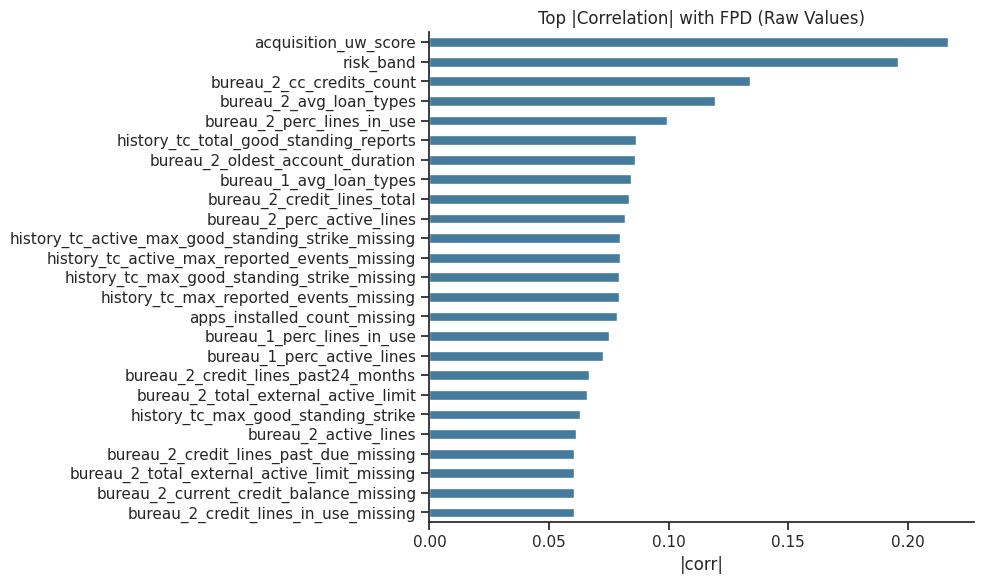

In [5]:
# =========================
# 2) Numeric Feature Screening
# =========================
import numpy as np

num_cols = [c for c in df.select_dtypes(include=np.number).columns if c != TARGET_COL]

# --- Compute raw correlations
corr_raw = df[num_cols].corrwith(df[TARGET_COL]).rename("corr_raw")

# --- Compute log1p correlations
df_log = df[num_cols].apply(lambda s: np.log1p(s.clip(lower=0)))  # avoids negatives
corr_log = df_log.corrwith(df[TARGET_COL]).rename("corr_log")

# --- Merge and add difference
corr_df = pd.concat([corr_raw, corr_log], axis=1)
corr_df["delta_abs"] = (corr_df["corr_log"].abs() - corr_df["corr_raw"].abs())
corr_df = corr_df.sort_values("corr_raw", key=lambda s: s.abs(), ascending=False)

display(corr_df.head(20))

# --- Optional: visualize top absolute correlations
plt.figure(figsize=(10,6))
top_abs = corr_df["corr_raw"].abs().sort_values(ascending=False).head(25)
top_abs.plot(kind="barh", color="#457b9d")
plt.gca().invert_yaxis()
plt.title("Top |Correlation| with FPD (Raw Values)")
plt.xlabel("|corr|")
plt.tight_layout()
plt.show()

## 5.2

In [6]:
# =========================
# 3) Quantile Binning for Decision Tree Inputs
# =========================
bin_dict = {}

for c in num_cols:
    if df[c].nunique(dropna=True) < 10:
        continue  # skip near-binary or discrete vars

    try:
        bins = pd.qcut(df[c], q=4, labels=False, duplicates="drop")
        bin_dict[f"{c}_band"] = bins
    except Exception:
        # skip problematic distributions
        continue

if bin_dict:
    df = pd.concat([df, pd.DataFrame(bin_dict, index=df.index)], axis=1).copy()
    print(f"Added {len(bin_dict)} binned numeric (_band) features.")
else:
    print("No binned numeric features created.")

Added 97 binned numeric (_band) features.


In [7]:
corr_df.to_csv("numeric_correlation_summary.csv", index=True)
print("Saved correlation summary → numeric_correlation_summary.csv")

Saved correlation summary → numeric_correlation_summary.csv


# 6. Categorical Screening and FPD gap analysis

In [8]:
import pandas as pd

# =========================
# 3.1 Identify categorical / binary variables (robust version)
# =========================

cat_cols = []
for c in df.columns:
    if c in [TARGET_COL, "risk_band"]:
        continue

    s = df[c]                      # pull Series directly
    col_dtype = s.dtype
    nunique = s.nunique(dropna=True)

    # robust categorical detection
    is_cat = (
        pd.api.types.is_object_dtype(col_dtype)
        or isinstance(col_dtype, pd.CategoricalDtype)
        or (nunique <= 10 and not pd.api.types.is_float_dtype(col_dtype))
    )

    if is_cat:
        cat_cols.append(c)

print(f"Found {len(cat_cols)} categorical/binary candidates.")

Found 146 categorical/binary candidates.


In [9]:
gap_records = []

for c in cat_cols:
    if df[c].dropna().nunique() < 2:
        continue  # skip constants

    tmp = df.groupby(c, dropna=False)[TARGET_COL].agg(["mean", "count"])
    tmp = tmp.rename(columns={"mean": "fpd_rate"})
    tmp = tmp[tmp["count"] >= 50]  # keep categories with enough volume

    if len(tmp) < 2:
        continue

    max_row = tmp["fpd_rate"].idxmax()
    min_row = tmp["fpd_rate"].idxmin()

    gap_records.append({
        "variable": c,
        "n_levels": tmp.shape[0],
        "max_fpd": tmp.loc[max_row, "fpd_rate"],
        "min_fpd": tmp.loc[min_row, "fpd_rate"],
        "fpd_gap": tmp["fpd_rate"].max() - tmp["fpd_rate"].min(),
        "high_risk_value": max_row,
        "low_risk_value": min_row
    })

gap_df = pd.DataFrame(gap_records).sort_values("fpd_gap", ascending=False).reset_index(drop=True)
print(f"{len(gap_df)} variables evaluated; showing top 15 by FPD gap:")
display(gap_df.head(15))

146 variables evaluated; showing top 15 by FPD gap:


,variable,n_levels,max_fpd,min_fpd,fpd_gap,high_risk_value,low_risk_value
0,uw_bucket,6,0.465997,0.130025,0.335972,[0.00‑0.80),[0.96‑1.00]
1,acquisition_uw_score_band,4,0.374298,0.157247,0.217051,0,3
2,phone_carrier,41,0.333333,0.132075,0.201258,at&t-miseleccion,diri
3,apps_installed_count_missing,2,0.331535,0.235911,0.095624,1,0
4,bureau_2_credit_lines_past24_months_missing,2,0.318370,0.239943,0.078427,0,1
5,bureau_2_credit_amount_past12_months_missing,2,0.318370,0.239943,0.078427,0,1
6,bureau_2_credit_lines_past_due_missing,2,0.318370,0.239943,0.078427,0,1
7,bureau_2_current_credit_balance_missing,2,0.318370,0.239943,0.078427,0,1
8,bureau_2_credit_lines_past12_months_missing,2,0.318370,0.239943,0.078427,0,1
9,bureau_2_current_balance_past_due_missing,2,0.318370,0.239943,0.078427,0,1


/tmp/ipython-input-1170182423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


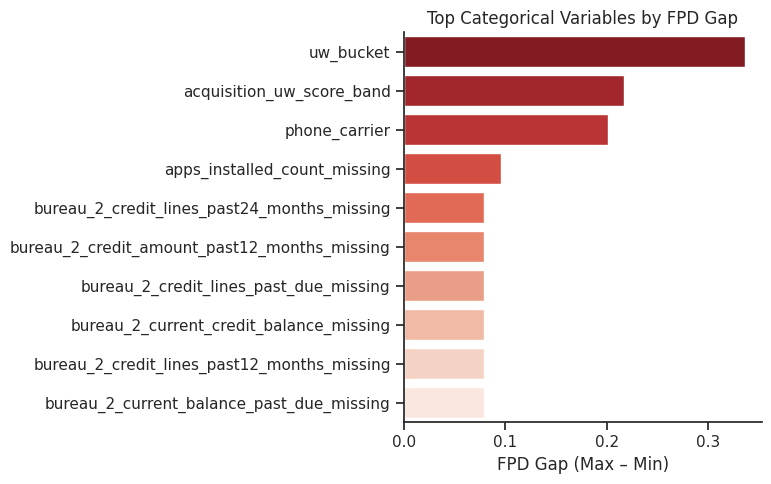

In [10]:
# Plot top 10 categorical FPD gaps
top_n = 10
plt.figure(figsize=(8, 5))
sns.barplot(
    data=gap_df.head(top_n),
    x="fpd_gap", y="variable", palette="Reds_r"
)
plt.title("Top Categorical Variables by FPD Gap")
plt.xlabel("FPD Gap (Max – Min)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [11]:
gap_df.to_csv("categorical_fpd_gap_summary.csv", index=False)
print("Saved → categorical_fpd_gap_summary.csv")

Saved → categorical_fpd_gap_summary.csv


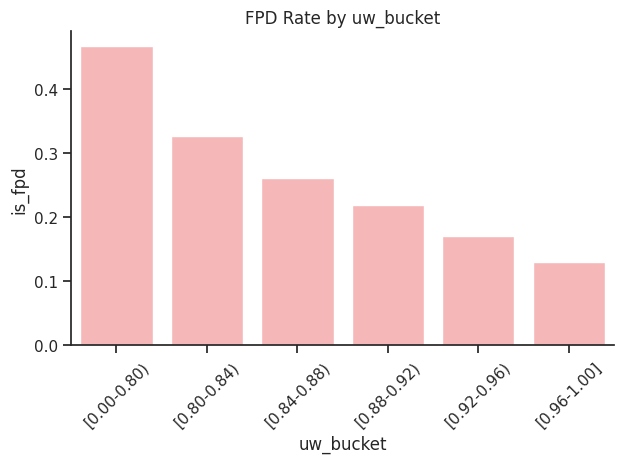

In [12]:
top_var = gap_df.loc[0, "variable"]
sns.barplot(
    data=df.groupby(top_var, dropna=False)[TARGET_COL].mean().reset_index(),
    x=top_var, y=TARGET_COL, color="#ffadad"
)
plt.title(f"FPD Rate by {top_var}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Decision Tree & Leaf Summaries

In [13]:
# =========================
# 4) Decision Tree & Leaf Summaries
# =========================
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split

# --- Define usable predictors (pre-application only)
exclude_cols = {TARGET_COL, "risk_band"} | set(POST_APP_EXCLUDE)
X = df.drop(columns=[c for c in df.columns if c in exclude_cols])
y = df[TARGET_COL]

print(f"Modeling on {X.shape[1]} features × {X.shape[0]:,} rows")

Modeling on 378 features × 182,462 rows


In [14]:
# Separate numeric / categorical
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# One-hot encode categoricals
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = pd.DataFrame(enc.fit_transform(X[cat_cols]),
                     columns=enc.get_feature_names_out(cat_cols),
                     index=X.index)

# Combine all
X_enc = pd.concat([X[num_cols].reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
print(f"Encoded {len(cat_cols)} categorical columns → {X_cat.shape[1]} features total={X_enc.shape[1]}")

Encoded 4 categorical columns → 53 features total=427


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_enc, y, test_size=0.3, random_state=42, stratify=y)

tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    min_samples_leaf=500,   # adjust for your dataset size
    random_state=42
)
tree.fit(X_train, y_train)
print(f"Train AUC≈{tree.score(X_train, y_train):.3f} | Val AUC≈{tree.score(X_val, y_val):.3f}")

Train AUC≈0.757 | Val AUC≈0.754


In [16]:
# Export readable tree text
tree_rules = export_text(tree, feature_names=list(X_enc.columns), decimals=3)
print(tree_rules[:1200])   # preview first lines

# Map each sample to its leaf
leaf_ids = tree.apply(X_enc)
leaf_summary = (
    pd.DataFrame({"leaf_id": leaf_ids, TARGET_COL: y})
      .groupby("leaf_id")[TARGET_COL]
      .agg(["mean", "count"])
      .rename(columns={"mean": "fpd_rate", "count": "samples"})
      .reset_index()
)
leaf_summary["share_%"] = 100 * leaf_summary["samples"] / len(df)
leaf_summary = leaf_summary.sort_values("fpd_rate", ascending=False)
display(leaf_summary.head(15))

|--- acquisition_uw_score <= 0.838
|   |--- acquisition_uw_score <= 0.690
|   |   |--- acquisition_uw_score <= 0.523
|   |   |   |--- referrer_unique_referrers <= 2.500
|   |   |   |   |--- class: 1
|   |   |   |--- referrer_unique_referrers >  2.500
|   |   |   |   |--- class: 1
|   |   |--- acquisition_uw_score >  0.523
|   |   |   |--- apps_installed_count <= 360.500
|   |   |   |   |--- class: 1
|   |   |   |--- apps_installed_count >  360.500
|   |   |   |   |--- class: 1
|   |--- acquisition_uw_score >  0.690
|   |   |--- apps_installed_count <= 471.000
|   |   |   |--- acquisition_uw_score <= 0.758
|   |   |   |   |--- class: 0
|   |   |   |--- acquisition_uw_score >  0.758
|   |   |   |   |--- class: 0
|   |   |--- apps_installed_count >  471.000
|   |   |   |--- acquisition_uw_score <= 0.781
|   |   |   |   |--- class: 1
|   |   |   |--- acquisition_uw_score >  0.781
|   |   |   |   |--- class: 0
|--- acquisition_uw_score >  0.838
|   |--- acquisition_uw_score <= 0.918
|   |  

,leaf_id,fpd_rate,samples,share_%
1,5,0.706522,1288,0.705900
3,8,0.666667,723,0.396247
0,4,0.630037,819,0.448861
6,14,0.560352,1135,0.622047
2,7,0.497392,5177,2.837303
7,15,0.438943,5675,3.110237
4,11,0.392904,4622,2.533130
11,23,0.330278,11239,6.159639
5,12,0.296848,18939,10.379695
8,19,0.251826,29429,16.128838


In [17]:
def extract_paths(decision_tree, feature_names):
    """Return list of rule strings (path to each leaf)."""
    from sklearn.tree import _tree
    tree_ = decision_tree.tree_
    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree_.feature[node]]
            thr  = tree_.threshold[node]
            left, right = tree_.children_left[node], tree_.children_right[node]
            recurse(left,  path + [f"{name} <= {thr:.3f}"])
            recurse(right, path + [f"{name} > {thr:.3f}"])
        else:
            paths.append(" & ".join(path))

    recurse(0, [])
    return paths

rule_paths = extract_paths(tree, list(X_enc.columns))
print(f"Extracted {len(rule_paths)} leaf paths.")

Extracted 16 leaf paths.


In [18]:
leaf_summary["path"] = rule_paths[:len(leaf_summary)]
leaf_summary = leaf_summary[["leaf_id", "samples", "share_%", "fpd_rate", "path"]]
leaf_summary.to_csv("tree_leaf_summary.csv", index=False)
display(leaf_summary.head(10))

,leaf_id,samples,share_%,fpd_rate,path
1,5,1288,0.705900,0.706522,acquisition_uw_score <= 0.838 & acquisition_uw...
3,8,723,0.396247,0.666667,acquisition_uw_score <= 0.838 & acquisition_uw...
0,4,819,0.448861,0.630037,acquisition_uw_score <= 0.838 & acquisition_uw...
6,14,1135,0.622047,0.560352,acquisition_uw_score <= 0.838 & acquisition_uw...
2,7,5177,2.837303,0.497392,acquisition_uw_score <= 0.838 & acquisition_uw...
7,15,5675,3.110237,0.438943,acquisition_uw_score <= 0.838 & acquisition_uw...
4,11,4622,2.533130,0.392904,acquisition_uw_score <= 0.838 & acquisition_uw...
11,23,11239,6.159639,0.330278,acquisition_uw_score <= 0.838 & acquisition_uw...
5,12,18939,10.379695,0.296848,acquisition_uw_score > 0.838 & acquisition_uw_...
8,19,29429,16.128838,0.251826,acquisition_uw_score > 0.838 & acquisition_uw_...


# 8. Rule Impact Simulation & Trade-off Visualizations

In [19]:
# =========================
# 5) Rule Impact Simulation
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"axes.spines.top": False, "axes.spines.right": False})

# ---- Load leaf summary produced in Step 4
leafs = pd.read_csv("tree_leaf_summary.csv")

# Filter for reasonable candidates: large enough sample & above-average FPD
avg_fpd = df[TARGET_COL].mean()
rules = (
    leafs.query("samples >= 500 and fpd_rate > @avg_fpd")
         .sort_values("fpd_rate", ascending=False)
         .head(10)  # adjust how many you want to test
)
display(rules[["leaf_id","samples","share_%","fpd_rate","path"]])

# Helper: ensure each rule is a string
rule_list = rules["path"].dropna().tolist()

,leaf_id,samples,share_%,fpd_rate,path
0,5,1288,0.705900,0.706522,acquisition_uw_score <= 0.838 & acquisition_uw...
1,8,723,0.396247,0.666667,acquisition_uw_score <= 0.838 & acquisition_uw...
2,4,819,0.448861,0.630037,acquisition_uw_score <= 0.838 & acquisition_uw...
3,14,1135,0.622047,0.560352,acquisition_uw_score <= 0.838 & acquisition_uw...
4,7,5177,2.837303,0.497392,acquisition_uw_score <= 0.838 & acquisition_uw...
5,15,5675,3.110237,0.438943,acquisition_uw_score <= 0.838 & acquisition_uw...
6,11,4622,2.533130,0.392904,acquisition_uw_score <= 0.838 & acquisition_uw...
7,23,11239,6.159639,0.330278,acquisition_uw_score <= 0.838 & acquisition_uw...
8,12,18939,10.379695,0.296848,acquisition_uw_score > 0.838 & acquisition_uw_...
9,19,29429,16.128838,0.251826,acquisition_uw_score > 0.838 & acquisition_uw_...


In [38]:
def mask_from_rule(df: pd.DataFrame, rule: str) -> pd.Series:
    """Safely evaluate a simple rule string (feature op threshold ... & ...)."""
    mask = pd.Series(True, index=df.index)
    for clause in rule.split("&"):
        clause = clause.strip()
        if not clause:
            continue
        try:
            col, op, thr = clause.split()[:3]
            val = pd.to_numeric(thr, errors="coerce")
            s = pd.to_numeric(df[col], errors="coerce")
            if op == "<=":
                mask &= (s <= val)
            elif op == ">":
                mask &= (s > val)
            elif op == "<":
                mask &= (s < val)
            elif op == ">=":
                mask &= (s >= val)
            elif op == "==":
                mask &= (s == val)
        except Exception:
            # silently ignore malformed clause
            continue
    return mask

def evaluate_rule(rule: str, df: pd.DataFrame, target: str = TARGET_COL) -> dict:
    """Compute baseline & filtered FPD stats for a given rule."""
    base_fpd = df[target].mean()
    remove_mask = mask_from_rule(df, rule)
    kept = df.loc[~remove_mask]
    kept_fpd = kept[target].mean()
    removed_fpd = df.loc[remove_mask, target].mean()
    removed_share = remove_mask.mean()
    return {
        "path": rule,  # Renamed 'rule' to 'path'
        "removed_%": 100 * removed_share,
        "fpd_removed_%": 100 * removed_fpd,
        "fpd_kept_%": 100 * kept_fpd,
        "fpd_reduction_pp": 100 * (base_fpd - kept_fpd)
    }

# --- Evaluate each rule independently
rule_eval = pd.DataFrame([evaluate_rule(r, df) for r in rule_list])
display(rule_eval.sort_values("fpd_reduction_pp", ascending=False))

,path,removed_%,fpd_removed_%,fpd_kept_%,fpd_reduction_pp
2,acquisition_uw_score <= 0.838 & acquisition_uw...,2.839495,49.700830,24.277841,0.721885
5,acquisition_uw_score <= 0.838 & acquisition_uw...,10.337495,29.726434,24.454768,0.544958
8,acquisition_uw_score > 0.838 & acquisition_uw_...,19.622716,26.983019,24.515540,0.484186
4,acquisition_uw_score <= 0.838 & acquisition_uw...,2.520525,39.269406,24.630755,0.368971
0,acquisition_uw_score <= 0.838 & acquisition_uw...,0.449409,62.926829,24.828509,0.171217
3,acquisition_uw_score <= 0.838 & acquisition_uw...,0.036172,43.939394,24.992873,0.006853
7,acquisition_uw_score <= 0.838 & acquisition_uw...,0.008769,37.500000,24.998630,0.001096
1,acquisition_uw_score <= 0.838 & acquisition_uw...,0.001096,100.000000,24.998904,0.000822
6,acquisition_uw_score <= 0.838 & acquisition_uw...,0.004933,33.333333,24.999315,0.000411
9,acquisition_uw_score > 0.838 & acquisition_uw_...,30.359746,22.305262,26.174380,-1.174654


In [39]:
# ---- Step 5.1 (append to the end): rank rules by impact ----
rule_eval = rule_eval.copy()

# Keep only meaningful rules: drop zeros/negatives (they raise FPD or do nothing)
rule_eval = rule_eval[(rule_eval["fpd_reduction_pp"] > 0) & (rule_eval["removed_%"] > 0)]

# Add an efficiency metric = FPD drop per 1% removed
rule_eval["efficiency"] = rule_eval["fpd_reduction_pp"] / rule_eval["removed_%"].replace(0, np.nan)

# Primary sort by absolute FPD drop, tiebreaker by efficiency
rule_eval_sorted = rule_eval.sort_values(
    by=["fpd_reduction_pp", "efficiency"],
    ascending=False,
).reset_index(drop=True)

# This ordered list will drive ALL later cumulative plots
ordered_paths = rule_eval_sorted["path"].tolist()

print("Top 10 rules by impact:")
display(rule_eval_sorted.head(10)[["path","fpd_reduction_pp","removed_%","efficiency"]])

Top 10 rules by impact:


,path,fpd_reduction_pp,removed_%,efficiency
0,acquisition_uw_score <= 0.838 & acquisition_uw...,0.721885,2.839495,0.254230
1,acquisition_uw_score <= 0.838 & acquisition_uw...,0.544958,10.337495,0.052717
2,acquisition_uw_score > 0.838 & acquisition_uw_...,0.484186,19.622716,0.024675
3,acquisition_uw_score <= 0.838 & acquisition_uw...,0.368971,2.520525,0.146387
4,acquisition_uw_score <= 0.838 & acquisition_uw...,0.171217,0.449409,0.380983
5,acquisition_uw_score <= 0.838 & acquisition_uw...,0.006853,0.036172,0.189465
6,acquisition_uw_score <= 0.838 & acquisition_uw...,0.001096,0.008769,0.125014
7,acquisition_uw_score <= 0.838 & acquisition_uw...,0.000822,0.001096,0.750011
8,acquisition_uw_score <= 0.838 & acquisition_uw...,0.000411,0.004933,0.083340


In [40]:
# ---- Step 5.1 (append to the end): rank rules by impact ----
rule_eval = rule_eval.copy()

# Keep only meaningful rules: drop zeros/negatives (they raise FPD or do nothing)
rule_eval = rule_eval[(rule_eval["fpd_reduction_pp"] > 0) & (rule_eval["removed_%"] > 0)]

# Add an efficiency metric = FPD drop per 1% removed
rule_eval["efficiency"] = rule_eval["fpd_reduction_pp"] / rule_eval["removed_%"].replace(0, np.nan)

# Primary sort by absolute FPD drop, tiebreaker by efficiency
rule_eval_sorted = rule_eval.sort_values(
    by=["fpd_reduction_pp", "efficiency"],
    ascending=False,
).reset_index(drop=True)

# This ordered list will drive ALL later cumulative plots
ordered_paths = rule_eval_sorted["path"].tolist()

print("Top 10 rules by impact:")
display(rule_eval_sorted.head(10)[["path","fpd_reduction_pp","removed_%","efficiency"]])

Top 10 rules by impact:


,path,fpd_reduction_pp,removed_%,efficiency
0,acquisition_uw_score <= 0.838 & acquisition_uw...,0.721885,2.839495,0.254230
1,acquisition_uw_score <= 0.838 & acquisition_uw...,0.544958,10.337495,0.052717
2,acquisition_uw_score > 0.838 & acquisition_uw_...,0.484186,19.622716,0.024675
3,acquisition_uw_score <= 0.838 & acquisition_uw...,0.368971,2.520525,0.146387
4,acquisition_uw_score <= 0.838 & acquisition_uw...,0.171217,0.449409,0.380983
5,acquisition_uw_score <= 0.838 & acquisition_uw...,0.006853,0.036172,0.189465
6,acquisition_uw_score <= 0.838 & acquisition_uw...,0.001096,0.008769,0.125014
7,acquisition_uw_score <= 0.838 & acquisition_uw...,0.000822,0.001096,0.750011
8,acquisition_uw_score <= 0.838 & acquisition_uw...,0.000411,0.004933,0.083340


In [41]:
def cumulative_eval(df, rules, target=TARGET_COL):
    results = []
    keep_mask = np.ones(len(df), dtype=bool)

    base_fpd = 100 * df[target].mean()
    results.append({"stage": "Baseline", "kept_%": 100, "fpd_%": base_fpd})

    for i, rule in enumerate(rules, start=1):
        remove = mask_from_rule(df, rule)
        keep_mask &= ~remove
        new_fpd = 100 * df.loc[keep_mask, target].mean()
        kept_pct = 100 * keep_mask.mean()
        results.append({
            "stage": f"After R{i}",
            "kept_%": kept_pct,
            "fpd_%": new_fpd,
            "fpd_reduction_pp": base_fpd - new_fpd
        })

    return pd.DataFrame(results)

cum_df = cumulative_eval(df, rule_list)
display(cum_df)

,stage,kept_%,fpd_%,fpd_reduction_pp
0,Baseline,100.000000,24.999726,NaN
1,After R1,99.550591,24.828509,0.171217
2,After R2,99.549495,24.827681,0.172045
3,After R3,96.710000,24.097382,0.902344
4,After R4,96.673828,24.089958,0.909768
5,After R5,94.153303,23.683598,1.316128
6,After R6,83.815808,22.938299,2.061427
7,After R7,83.810876,22.937688,2.062038
8,After R8,83.802107,22.936164,2.063562
9,After R9,64.179391,21.698846,3.300880


## 5.4 Visualization

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({"axes.spines.top": False, "axes.spines.right": False})

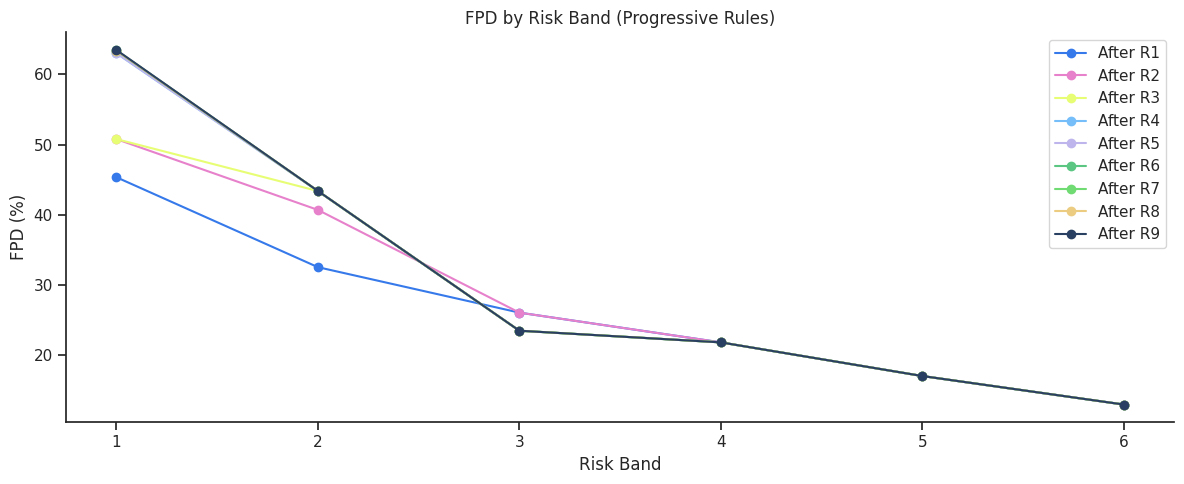

In [48]:
# Full list of bands we expect on the x-axis
risk_bands_full = sorted(df["risk_band"].dropna().unique())

def fpd_by_band_table(frame, target_col=TARGET_COL, bands=risk_bands_full):
    # returns a 1D Series aligned to full band list (even if a band disappears after filtering)
    s = frame.groupby("risk_band")[target_col].mean() * 100.0
    return s.reindex(bands).fillna(0.0)

# Build cumulative kept masks using the newly sorted rules
keep = np.ones(len(df), dtype=bool)
fpd_matrix = []  # list of arrays aligned to risk_bands_full
stage_labels = []

for i, path in enumerate(ordered_paths, start=1):
    # remove current rule from what's left
    rm = mask_from_rule(df, path)  # <- same function you already use
    keep &= ~rm
    fpd_series = fpd_by_band_table(df.loc[keep])
    fpd_matrix.append(fpd_series.values)
    stage_labels.append(f"After R{i}")

# Plot safely with aligned x/y lengths
plt.figure(figsize=(12,5))
for i, arr in enumerate(fpd_matrix, start=1):
    plt.plot(risk_bands_full, arr, marker="o", label=stage_labels[i-1])
plt.title("FPD by Risk Band (Progressive Rules)")
plt.xlabel("Risk Band"); plt.ylabel("FPD (%)")
plt.legend()
plt.tight_layout(); plt.show()

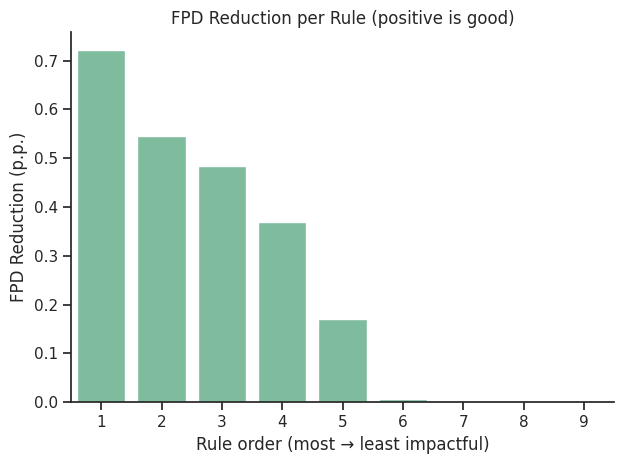

In [51]:
ax = sns.barplot(
    data=rule_eval_sorted,
    x=np.arange(len(rule_eval_sorted)) + 1,
    y=rule_eval_sorted["fpd_reduction_pp"],   # positive means FPD ↓
    color="#74c69d"
)
ax.set_xlabel("Rule order (most → least impactful)")
ax.set_ylabel("FPD Reduction (p.p.)")
ax.set_title("FPD Reduction per Rule (positive is good)")
plt.tight_layout(); plt.show()

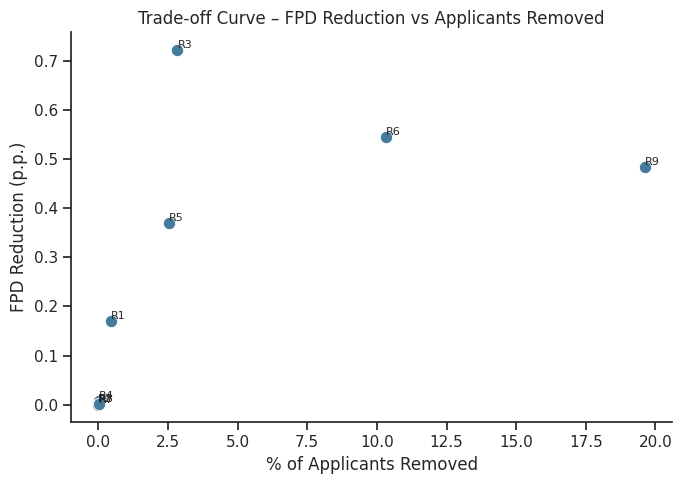

In [47]:
rule_eval['rule'] = rule_eval['path']


plt.figure(figsize=(7,5))
sns.scatterplot(
    data=rule_eval, x="removed_%", y="fpd_reduction_pp",
    s=80, color="#457b9d"
)
plt.plot(rule_eval["removed_%"], rule_eval["fpd_reduction_pp"], lw=0, alpha=0.6)
for i, r in enumerate(rule_eval["rule"].index):
    plt.text(rule_eval["removed_%"].iloc[i],
             rule_eval["fpd_reduction_pp"].iloc[i],
             f"R{i+1}", fontsize=8, ha="left", va="bottom")
plt.title("Trade-off Curve – FPD Reduction vs Applicants Removed")
plt.xlabel("% of Applicants Removed")
plt.ylabel("FPD Reduction (p.p.)")
plt.tight_layout()
plt.show()

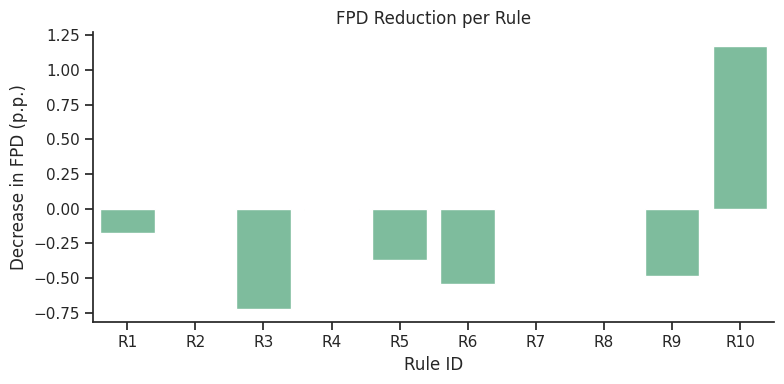

In [33]:
plt.figure(figsize=(8,4))
sns.barplot(data=rule_eval, x=rule_eval.index,
            y=-rule_eval["fpd_reduction_pp"], color="#74c69d")
plt.ylabel("Decrease in FPD (p.p.)")
plt.xticks(ticks=range(len(rule_eval)), labels=[f"R{i+1}" for i in range(len(rule_eval))])
plt.title("FPD Reduction per Rule")
plt.xlabel("Rule ID")
plt.tight_layout()
plt.show()

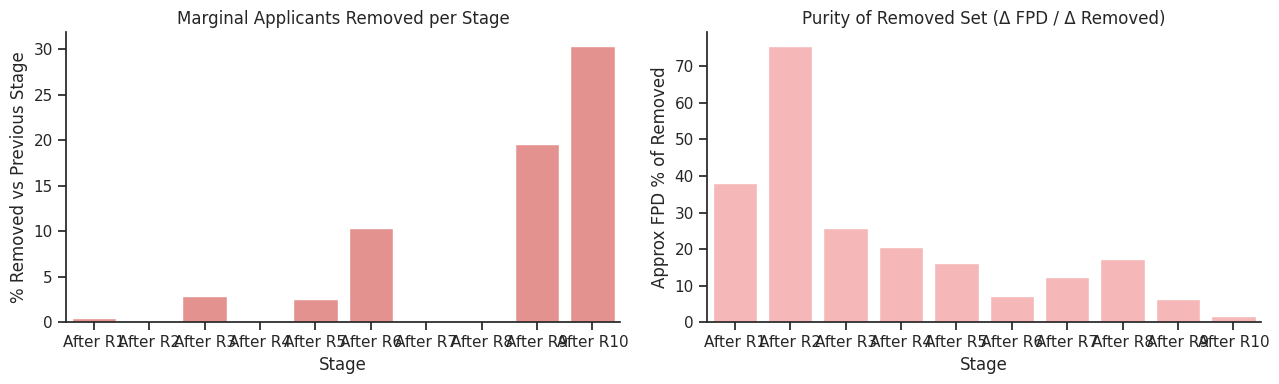

In [25]:
# compute marginal (each rule removes vs prior)
cum_df["removed_%"] = 100 - cum_df["kept_%"]
cum_df["marginal_removed_%"] = cum_df["removed_%"].diff().fillna(0)
cum_df["marginal_fpd_%"] = cum_df["fpd_%"].shift().fillna(cum_df["fpd_%"].iloc[0]) - cum_df["fpd_%"]

# purity = FPD rate among the removed portion (approximation)
cum_df["removed_purity_%"] = cum_df["marginal_fpd_%"] / cum_df["marginal_removed_%"] * 100

fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.barplot(data=cum_df.iloc[1:], x="stage", y="marginal_removed_%", ax=ax[0], color="#f28482")
ax[0].set_title("Marginal Applicants Removed per Stage")
ax[0].set_ylabel("% Removed vs Previous Stage"); ax[0].set_xlabel("Stage")

sns.barplot(data=cum_df.iloc[1:], x="stage", y="removed_purity_%", ax=ax[1], color="#ffadad")
ax[1].set_title("Purity of Removed Set (Δ FPD / Δ Removed)")
ax[1].set_ylabel("Approx FPD % of Removed"); ax[1].set_xlabel("Stage")

plt.tight_layout(); plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

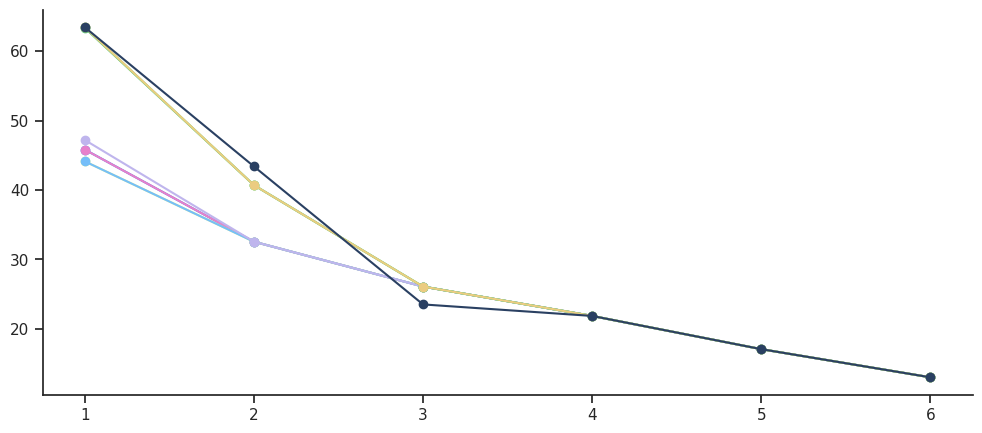

In [53]:
def fpd_by_band(df, target=TARGET_COL):
    return 100 * df.groupby("risk_band")[target].mean().reindex(sorted(df["risk_band"].dropna().unique()))

risk_bands = sorted(df["risk_band"].dropna().unique())
fpd_matrix = []

keep_mask = np.ones(len(df), dtype=bool)
for i, rule in enumerate(rule_list, start=1):
    remove = mask_from_rule(df, rule)
    keep_mask &= ~remove
    fpd_matrix.append(fpd_by_band(df.loc[keep_mask]).values)

plt.figure(figsize=(12,5))
for i, arr in enumerate(fpd_matrix, start=1):
    plt.plot(risk_bands, arr, marker="o", label=f"After R{i}")
plt.title("FPD by Risk Band (Progressive Rules)")
plt.xlabel("Risk Band"); plt.ylabel("FPD (%)")
plt.legend(); plt.tight_layout(); plt.show()

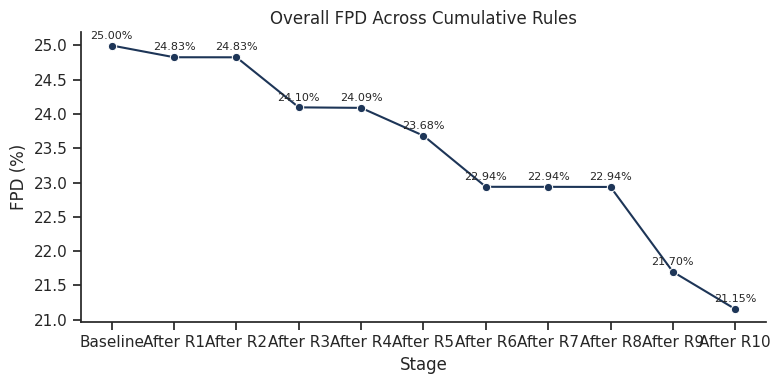

In [54]:
plt.figure(figsize=(8,4))
sns.lineplot(data=cum_df, x="stage", y="fpd_%", marker="o", color="#1d3557")
plt.title("Overall FPD Across Cumulative Rules")
plt.ylabel("FPD (%)"); plt.xlabel("Stage")
for i,v in enumerate(cum_df["fpd_%"]):
    plt.text(i, v + 0.1, f"{v:.2f}%", ha="center", fontsize=8)
plt.tight_layout(); plt.show()

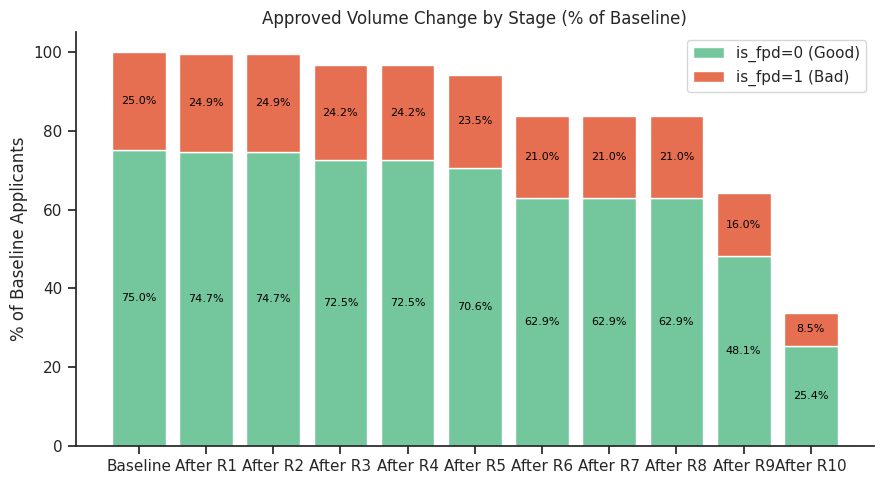

In [29]:
base_good = 100 * (1 - df[TARGET_COL].mean())
base_bad  = 100 * df[TARGET_COL].mean()
cum_df["good_%"] = base_good * cum_df["kept_%"] / 100
cum_df["bad_%"]  = base_bad  * cum_df["kept_%"] / 100

plt.figure(figsize=(9,5))
bars_good = plt.bar(cum_df["stage"], cum_df["good_%"], label="is_fpd=0 (Good)", color="#74c69d")
bars_bad = plt.bar(cum_df["stage"], cum_df["bad_%"], bottom=cum_df["good_%"], label="is_fpd=1 (Bad)", color="#e76f51")
plt.title("Approved Volume Change by Stage (% of Baseline)")
plt.ylabel("% of Baseline Applicants"); plt.legend()

# Add labels to bars
for bar_good, bar_bad in zip(bars_good, bars_bad):
    height_good = bar_good.get_height()
    height_bad = bar_bad.get_height()
    plt.text(bar_good.get_x() + bar_good.get_width()/2., height_good/2.,
             f'{height_good:.1f}%',
             ha="center", va="center", fontsize=8, color="black")
    plt.text(bar_bad.get_x() + bar_bad.get_width()/2., height_good + height_bad/2.,
             f'{height_bad:.1f}%',
             ha="center", va="center", fontsize=8, color="black")

plt.tight_layout(); plt.show()

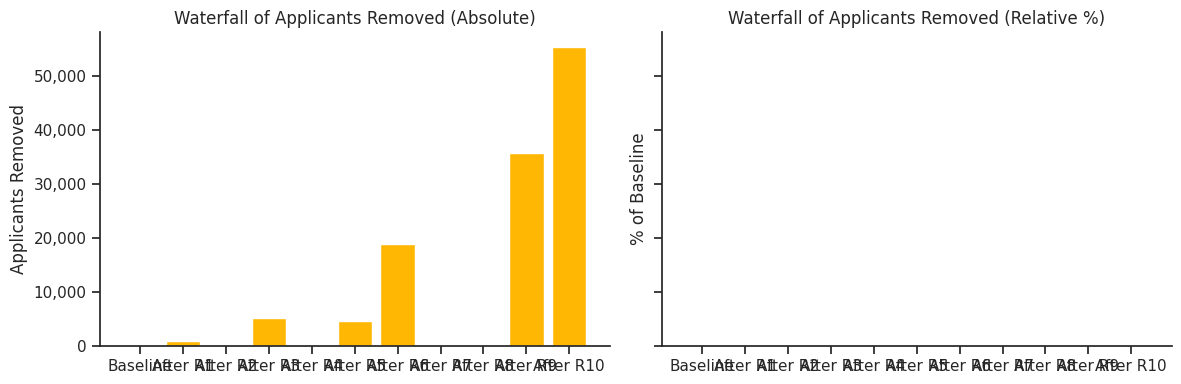

In [30]:
import matplotlib.ticker as mtick

base_total = len(df)
stages = cum_df["stage"].tolist()
removed_counts = [0] + list(np.diff((100 - cum_df["kept_%"]) / 100 * base_total))

fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)

# Absolute waterfall
ax[0].bar(stages, removed_counts, color="#ffb703")
ax[0].set_title("Waterfall of Applicants Removed (Absolute)")
ax[0].set_ylabel("Applicants Removed"); ax[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Relative (% of baseline)
rel_removed = np.array(removed_counts)/base_total*100
ax[1].bar(stages, rel_removed, color="#fb8500")
ax[1].set_title("Waterfall of Applicants Removed (Relative %)")
ax[1].set_ylabel("% of Baseline")

plt.tight_layout(); plt.show()

In [55]:
def mask_from_rule(frame, path_expr):
    """
    Build a boolean mask from a 'path' like:
    'risk_band > 5.50 & apps_installed_count_missing_band <= 0.50 & bureau_2_perc_lines_in_use_band > 1.50'
    Assumes all referenced columns exist in `frame`.
    """
    # Create a safe eval namespace with Series aligned to frame
    ns = {c: frame[c] for c in frame.columns}

    # If any referenced column is categorical, cast to numeric where possible
    # (you can tailor this if you need specific casts)
    for var in [tok.strip().split()[0] for tok in path_expr.split("&")]:
        if var in ns and pd.api.types.is_categorical_dtype(ns[var].dtype):
            try:
                ns[var] = pd.to_numeric(ns[var].astype(str), errors="coerce")
            except Exception:
                pass  # fallback to string comparisons if needed

    # Evaluate the boolean expression
    mask = pd.eval(path_expr, engine="python", local_dict=ns)

    # Ensure boolean dtype
    if mask.dtype != bool:
        mask = mask.astype(bool)

    # Align to frame.index just in case
    return mask.reindex(frame.index, fill_value=False)

# 6.

In [58]:
# =========================
# Step 6 — Auto-pick ideal #rules and print a summary
# =========================
import numpy as np
import pandas as pd

# ---------- Configurable knobs ----------
MAX_RULES          = 25          # evaluate first K rules from ordered_paths
MAX_REMOVED_PCT    = 12.0        # cap on % of applicants removed (global)
MIN_FPD_DROP_PP    = 2.0         # target: at least this many p.p. FPD improvement vs baseline
MIN_MARGINAL_EFF   = 0.02        # stop if marginal efficiency (ΔFPD/Δremoved) falls below this

# ---------- Safety: slice rules we’ll consider ----------
rules_for_search = ordered_paths[:min(MAX_RULES, len(ordered_paths))]

# ---------- Helper to apply a rule cumulatively ----------
def evaluate_rules_cumulative(df, rules, target_col="is_fpd"):
    """
    Returns:
      stages_df: one row per cumulative stage (Baseline, After R1, After R1+R2, ...)
      masks:     list of boolean masks 'kept' for each stage (aligned to df.index)
    """
    N = len(df)
    kept = np.ones(N, dtype=bool)
    masks = [kept.copy()]    # stage 0 = baseline
    rows = [{
        "stage": "Baseline",
        "k_rules": 0,
        "kept_n": int(kept.sum()),
        "kept_%": 100.0 * kept.mean(),
        "removed_%": 0.0,
        "overall_fpd_%": 100.0 * df.loc[kept, target_col].mean(),
        "delta_removed_%": 0.0,
        "delta_fpd_pp": 0.0,
        "marginal_eff": np.nan,   # ΔFPD / ΔRemoved (pp per 1% removed)
    }]

    prev_kept = kept.copy()
    prev_fpd  = rows[-1]["overall_fpd_%"]
    prev_kept_pct = rows[-1]["kept_%"]

    for i, path in enumerate(rules, start=1):
        rm = mask_from_rule(df, path)
        kept = kept & (~rm)  # cumulative keep

        kept_n = int(kept.sum())
        kept_pct = 100.0 * kept.mean()
        removed_pct = 100.0 - kept_pct
        fpd = 100.0 * df.loc[kept, target_col].mean()

        # marginal deltas vs previous stage
        delta_removed = prev_kept_pct - kept_pct
        delta_fpd     = prev_fpd - fpd
        marginal_eff  = (delta_fpd / delta_removed) if delta_removed > 1e-9 else np.nan

        rows.append({
            "stage": f"After R{i}",
            "k_rules": i,
            "kept_n": kept_n,
            "kept_%": kept_pct,
            "removed_%": removed_pct,
            "overall_fpd_%": fpd,
            "delta_removed_%": delta_removed,
            "delta_fpd_pp": delta_fpd,
            "marginal_eff": marginal_eff
        })

        masks.append(kept.copy())
        prev_fpd, prev_kept_pct = fpd, kept_pct

    stages_df = pd.DataFrame(rows)
    return stages_df, masks

import re
import numpy as np
import pandas as pd

# --- tiny slugify used to match rule value names to raw string values ---
def _slugify_value(x: str) -> str:
    if pd.isna(x):
        return "none"
    s = str(x).strip().lower()
    # collapse non-alphanumerics to underscores
    s = re.sub(r"[^0-9a-z]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s or "none"

def _extract_lhs_tokens(rule: str) -> list[str]:
    """
    Grabs the LHS tokens (column-like names) from a rule such as:
      "phone_carrier_none == 1 & risk_band > 5.5"
    -> ["phone_carrier_none", "risk_band"]
    """
    toks = []
    for chunk in re.split(r"\s*&\s*|\s*\|\s*", rule):  # split on & or |
        part = chunk.strip()
        if not part:
            continue
        lhs = part.split()[0]
        toks.append(lhs)
    return toks

def _guess_base_col(token: str, cols: set[str]) -> str | None:
    """
    For a missing token like 'phone_carrier_none', find the longest
    prefix that matches an existing column, split by underscores.
    """
    if token in cols:
        return token
    # try progressively shorter prefixes
    parts = token.split("_")
    for cut in range(len(parts) - 1, 0, -1):
        cand = "_".join(parts[:cut])
        if cand in cols:
            return cand
    return None

def ensure_missing_rule_columns(df: pd.DataFrame, rules: list[str]) -> list[str]:
    """
    Ensures any one-hot columns referenced by rules exist in df.
    For a missing token like 'pi_occupation_private_employee', this will
    create df['pi_occupation_private_employee'] = 1{slug(pi_occupation)=='private_employee'}.
    Returns list of columns it created.
    """
    created = []
    cols = set(df.columns)

    # precompute slugified string views for all object/category cols
    str_views: dict[str, pd.Series] = {}
    for c in df.columns:
        dt = df[c].dtype
        if isinstance(dt, pd.CategoricalDtype) or dt == object:
            str_views[c] = df[c].astype(object).map(_slugify_value)

    for rule in rules:
        for token in _extract_lhs_tokens(rule):
            if token in cols:
                continue  # already present
            base = _guess_base_col(token, cols)
            if base is None:
                # not derivable from an existing column; skip (will still error if used)
                continue

            # If the base is numeric/band, we can't derive dummy -> skip.
            if base not in str_views:
                continue

            # Value slug = token minus the matched base + underscore
            value_slug = token[len(base):].lstrip("_")
            if not value_slug:
                continue

            # Create the dummy column
            df[token] = (str_views[base] == value_slug).astype(int)
            created.append(token)
            cols.add(token)

    return created

# ---- Run it on the rules you are about to evaluate ----
new_cols = ensure_missing_rule_columns(df, rules_for_search)  # or "ordered_paths" if that's your list
if new_cols:
    print(f"Created {len(new_cols)} derived rule columns:", new_cols[:10], "..." if len(new_cols) > 10 else "")
else:
    print("No derived rule columns were needed.")

# ---------- Run the cumulative evaluation on the sorted rules ----------
stages_df, kept_masks = evaluate_rules_cumulative(df, rules_for_search, target_col=TARGET_COL)

# ---------- Pick the "ideal" K by a few sensible criteria ----------
baseline_fpd = stages_df.loc[0, "overall_fpd_%"]

# (A) meet target FPD drop & removal cap; among those, pick smallest removed_% (or largest fpd drop if you prefer)
candidates_A = stages_df[
    (stages_df["k_rules"] > 0) &
    (baseline_fpd - stages_df["overall_fpd_%"] >= MIN_FPD_DROP_PP) &
    (stages_df["removed_%"] <= MAX_REMOVED_PCT)
]
best_A = (
    candidates_A.sort_values(["removed_%","overall_fpd_%"], ascending=[True, True])
    .head(1)
)

# (B) elbow via marginal efficiency (stop when Δfpd/Δremoved < threshold)
stages_df["ok_marginal"] = stages_df["marginal_eff"].fillna(np.inf) >= MIN_MARGINAL_EFF
last_ok_idx = stages_df.index[stages_df["ok_marginal"]].max() if stages_df["ok_marginal"].any() else 0
best_B = stages_df.loc[[last_ok_idx]] if last_ok_idx > 0 else pd.DataFrame()

# (C) absolute minimum FPD (subject to removal cap)
candidates_C = stages_df[(stages_df["k_rules"] > 0) & (stages_df["removed_%"] <= MAX_REMOVED_PCT)]
best_C = candidates_C.sort_values("overall_fpd_%", ascending=True).head(1)

# Prefer (A), then (B), then (C)
if len(best_A):
    chosen = best_A.iloc[0]
    pick_reason = f"Meets ≥{MIN_FPD_DROP_PP:.1f}pp drop and ≤{MAX_REMOVED_PCT:.1f}% removed (min removed)."
elif len(best_B):
    chosen = best_B.iloc[0]
    pick_reason = f"Elbow on marginal efficiency (≥{MIN_MARGINAL_EFF:.3f} pp FPD drop per 1% removed)."
elif len(best_C):
    chosen = best_C.iloc[0]
    pick_reason = f"Lowest overall FPD within ≤{MAX_REMOVED_PCT:.1f}% removal cap."
else:
    # fallback = do nothing beyond baseline
    chosen = stages_df.iloc[0]
    pick_reason = "No rule set met constraints; keeping Baseline."

BEST_K = int(chosen["k_rules"])
print(f"\nBest K = {BEST_K}  |  Reason: {pick_reason}")
display(chosen.to_frame().T)

# ---------- Human-readable summary of the filters applied ----------
if BEST_K > 0:
    final_keep = kept_masks[BEST_K]
    removed_mask = ~final_keep
    removed_df = df.loc[removed_mask]

    # Top-level counts
    total_removed = int(removed_mask.sum())
    total_kept    = int(final_keep.sum())
    fpd_before    = 100.0 * df[TARGET_COL].mean()
    fpd_after     = 100.0 * df.loc[final_keep, TARGET_COL].mean()
    drop_pp       = fpd_before - fpd_after

    print("\n=== SUMMARY OF SELECTED FILTERS ===")
    print(f"Rules chosen (in order):\n")
    for i in range(BEST_K):
        print(f"  R{i+1}: {rules_for_search[i]}")

    print("\nImpact:")
    print(f"  Applicants kept:   {total_kept:,}  ({100*total_kept/len(df):.2f}%)")
    print(f"  Applicants removed:{total_removed:,}  ({100*total_removed/len(df):.2f}%)")
    print(f"  Overall FPD: {fpd_before:.2f}%  →  {fpd_after:.2f}%   (Δ {drop_pp:.2f} p.p.)")

    # What got removed? (by risk band and by is_fpd purity)
    by_band = (
        removed_df.groupby("risk_band")[TARGET_COL]
        .agg(removed_n="count", bad_n="sum")
        .assign(good_n=lambda x: x["removed_n"] - x["bad_n"],
                bad_pct=lambda x: 100.0 * x["bad_n"] / x["removed_n"].replace(0, np.nan))
        .reset_index()
        .sort_values(["risk_band"])
    )

    print("\nRemoved composition by risk_band:")
    display(by_band)

    # Per-rule marginal summary (what each rule removed *at the time it was applied*)
    print("\nPer-rule marginal impact (applied in order):")
    prev_keep = np.ones(len(df), dtype=bool)
    marginal_rows = []
    for i in range(BEST_K):
        rm_i = mask_from_rule(df.loc[prev_keep], rules_for_search[i])
        # map back to full index
        removed_i_mask = prev_keep.copy()
        removed_i_mask[prev_keep] = rm_i.values
        # restrict to those not already removed earlier
        removed_i_mask = removed_i_mask & prev_keep

        seg = df.loc[removed_i_mask]
        marginal_rows.append({
            "rule_id": f"R{i+1}",
            "path": rules_for_search[i],
            "removed_n": int(removed_i_mask.sum()),
            "removed_%_of_base": 100.0 * removed_i_mask.mean(),
            "fpd_%_in_removed": 100.0 * seg[TARGET_COL].mean() if len(seg) else np.nan
        })
        # update keep for next iteration
        prev_keep = prev_keep & (~removed_i_mask)

    marginal_df = pd.DataFrame(marginal_rows)
    display(marginal_df)

else:
    print("\nNo rules selected under current constraints. Consider relaxing MAX_REMOVED_PCT or lowering MIN_FPD_DROP_PP.")

# ---------- Full stages table for the appendix ----------
print("\nFull stages table (Baseline → After each rule):")
display(stages_df)

Created 1 derived rule columns: ['phone_carrier_none'] 

Best K = 9  |  Reason: Elbow on marginal efficiency (≥0.020 pp FPD drop per 1% removed).


/tmp/ipython-input-3907364089.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if var in ns and pd.api.types.is_categorical_dtype(ns[var].dtype):


,stage,k_rules,kept_n,kept_%,removed_%,overall_fpd_%,delta_removed_%,delta_fpd_pp,marginal_eff,ok_marginal
9,After R9,9,129300,70.86407,29.13593,22.591647,0.004933,0.000748,0.151571,True



=== SUMMARY OF SELECTED FILTERS ===
Rules chosen (in order):

  R1: acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count <= 360.500
  R2: acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score > 0.758
  R3: acquisition_uw_score > 0.838 & acquisition_uw_score <= 0.918 & phone_carrier_none <= 0.500 & acquisition_uw_score <= 0.871
  R4: acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score <= 0.758
  R5: acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers <= 2.500
  R6: acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count > 360.500
  R7: acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score > 0.781
  R8: acqu

,risk_band,removed_n,bad_n,good_n,bad_pct
0,1,14480,6170,8310,42.610497
1,2,15814,4553,11261,28.790945
2,3,22868,5681,17187,24.842575



Per-rule marginal impact (applied in order):


/tmp/ipython-input-3907364089.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if var in ns and pd.api.types.is_categorical_dtype(ns[var].dtype):


,rule_id,path,removed_n,removed_%_of_base,fpd_%_in_removed
0,R1,acquisition_uw_score <= 0.838 & acquisition_uw...,5181,2.839495,49.700830
1,R2,acquisition_uw_score <= 0.838 & acquisition_uw...,18862,10.337495,29.726434
2,R3,acquisition_uw_score > 0.838 & acquisition_uw_...,23607,12.938036,24.823146
3,R4,acquisition_uw_score <= 0.838 & acquisition_uw...,4599,2.520525,39.269406
4,R5,acquisition_uw_score <= 0.838 & acquisition_uw...,820,0.449409,62.926829
5,R6,acquisition_uw_score <= 0.838 & acquisition_uw...,66,0.036172,43.939394
6,R7,acquisition_uw_score <= 0.838 & acquisition_uw...,16,0.008769,37.500000
7,R8,acquisition_uw_score <= 0.838 & acquisition_uw...,2,0.001096,100.000000
8,R9,acquisition_uw_score <= 0.838 & acquisition_uw...,9,0.004933,33.333333



Full stages table (Baseline → After each rule):


,stage,k_rules,kept_n,kept_%,removed_%,overall_fpd_%,delta_removed_%,delta_fpd_pp,marginal_eff,ok_marginal
0,Baseline,0,182462,100.000000,0.000000,24.999726,0.000000,0.000000,NaN,True
1,After R1,1,177281,97.160505,2.839495,24.277841,2.839495,0.721885,0.254230,True
2,After R2,2,158419,86.823010,13.176990,23.629110,10.337495,0.648731,0.062755,True
3,After R3,3,134812,73.884973,26.115027,23.420022,12.938036,0.209088,0.016161,False
4,After R4,4,130213,71.364448,28.635552,22.860237,2.520525,0.559785,0.222091,True
5,After R5,5,129393,70.915040,29.084960,22.606323,0.449409,0.253913,0.564994,True
6,After R6,6,129327,70.878868,29.121132,22.595436,0.036172,0.010887,0.300979,True
7,After R7,7,129311,70.870099,29.129901,22.593592,0.008769,0.001844,0.210308,True
8,After R8,8,129309,70.869003,29.130997,22.592395,0.001096,0.001197,1.092246,True
9,After R9,9,129300,70.864070,29.135930,22.591647,0.004933,0.000748,0.151571,True


### Impact of R on 1,4,5,6,7,8,9,2

=== Impact of Selected Rules (Cumulative) ===


,stage,k_rules,kept_n,kept_%,removed_%,overall_fpd_%,delta_removed_%,delta_fpd_pp,marginal_eff
0,Baseline,0,182462,100.000000,0.000000,24.999726,0.000000,0.000000,NaN
1,After R1,1,177281,97.160505,2.839495,24.277841,2.839495,0.721885,0.254230
2,After R2,2,172682,94.639980,5.360020,23.878574,2.520525,0.399267,0.158406
3,After R3,3,171862,94.190571,5.809429,23.692265,0.449409,0.186310,0.414566
4,After R4,4,171796,94.154399,5.845601,23.684486,0.036172,0.007778,0.215042
5,After R5,5,171780,94.145630,5.854370,23.683199,0.008769,0.001287,0.146746
6,After R6,6,171778,94.144534,5.855466,23.682311,0.001096,0.000889,0.810634
7,After R7,7,171769,94.139602,5.860398,23.681805,0.004933,0.000506,0.102518



Final summary after 7 rules:
  Applicants kept: 94.14%
  FPD reduced: 1.32 p.p.  (from 25.00% → 23.68%)


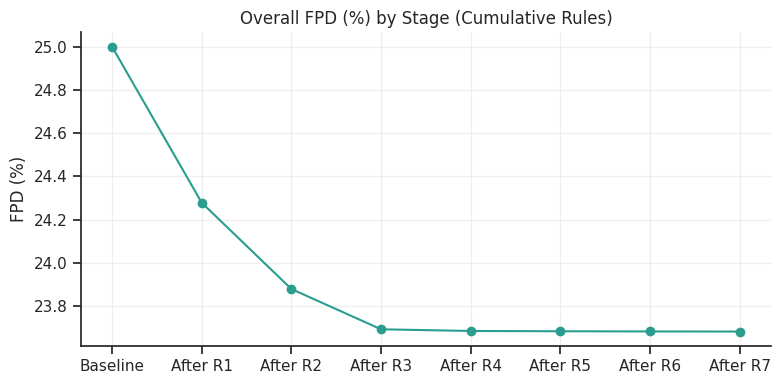

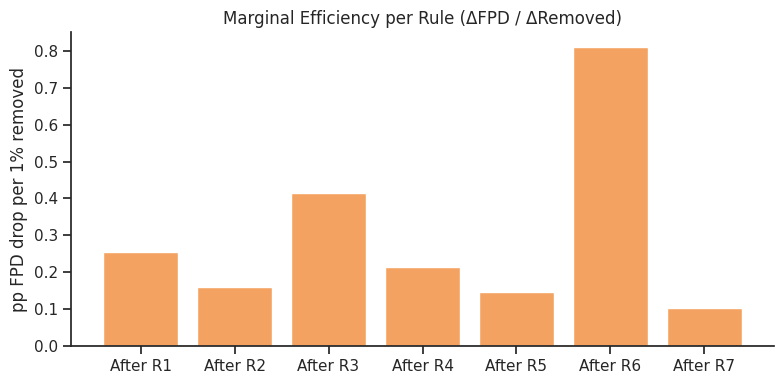

In [79]:
# ===============================
# EVALUATE IMPACT OF SELECTED RULES (R1, R4, R5, R6)
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
TARGET_COL = "is_fpd"

selected_rules = [
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count <= 360.500",  # R1
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score <= 0.758",  # R4
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers <= 2.500",  # R5
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count > 360.500",   # R6
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score > 0.781", #R7
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers > 2.500", # R8
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score <= 0.781", # R9
    #"acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score > 0.758" # R2
]

# --- SAFETY: ensure numeric types for involved columns ---
for col in ["acquisition_uw_score", "apps_installed_count", "referrer_unique_referrers"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# --- helper to evaluate rules cumulatively ---
def evaluate_selected_rules(df, rules, target_col=TARGET_COL):
    N = len(df)
    kept = np.ones(N, dtype=bool)
    prev_kept_pct = 100.0
    prev_fpd = 100.0 * df[target_col].mean()
    rows = [{
        "stage": "Baseline",
        "k_rules": 0,
        "kept_n": kept.sum(),
        "kept_%": 100.0,
        "removed_%": 0.0,
        "overall_fpd_%": prev_fpd,
        "delta_removed_%": 0.0,
        "delta_fpd_pp": 0.0,
        "marginal_eff": np.nan
    }]
    masks = [kept.copy()]

    for i, rule in enumerate(rules, start=1):
        try:
            rm = pd.eval(rule, engine="python", local_dict=df)
        except Exception as e:
            print(f"⚠️ Error evaluating rule {i}: {e}")
            continue

        # Cumulative filtering
        kept = kept & (~rm)

        kept_n = kept.sum()
        kept_pct = 100.0 * kept.mean()
        removed_pct = 100.0 - kept_pct
        fpd = 100.0 * df.loc[kept, target_col].mean()

        delta_removed = prev_kept_pct - kept_pct
        delta_fpd = prev_fpd - fpd
        marginal_eff = (delta_fpd / delta_removed) if delta_removed > 1e-9 else np.nan

        rows.append({
            "stage": f"After R{i}",
            "k_rules": i,
            "kept_n": kept_n,
            "kept_%": kept_pct,
            "removed_%": removed_pct,
            "overall_fpd_%": fpd,
            "delta_removed_%": delta_removed,
            "delta_fpd_pp": delta_fpd,
            "marginal_eff": marginal_eff
        })

        prev_kept_pct, prev_fpd = kept_pct, fpd
        masks.append(kept.copy())

    stages_df = pd.DataFrame(rows)
    return stages_df, masks

# --- RUN EVALUATION ---
stages_df, masks = evaluate_selected_rules(df, selected_rules, target_col=TARGET_COL)

print("=== Impact of Selected Rules (Cumulative) ===")
display(stages_df)

# --- SUMMARY OF BASELINE VS FINAL ---
base_fpd = stages_df.loc[0, "overall_fpd_%"]
final_fpd = stages_df.iloc[-1]["overall_fpd_%"]
drop_pp = base_fpd - final_fpd
kept_pct = stages_df.iloc[-1]["kept_%"]

print(f"\nFinal summary after {len(selected_rules)} rules:")
print(f"  Applicants kept: {kept_pct:.2f}%")
print(f"  FPD reduced: {drop_pp:.2f} p.p.  (from {base_fpd:.2f}% → {final_fpd:.2f}%)")

# --- PLOT: FPD vs Stage ---
plt.figure(figsize=(8,4))
plt.plot(stages_df["stage"], stages_df["overall_fpd_%"], marker="o", color="#2a9d8f")
plt.title("Overall FPD (%) by Stage (Cumulative Rules)")
plt.ylabel("FPD (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT: Marginal efficiency ---
plt.figure(figsize=(8,4))
plt.bar(stages_df["stage"].iloc[1:], stages_df["marginal_eff"].iloc[1:], color="#f4a261")
plt.title("Marginal Efficiency per Rule (ΔFPD / ΔRemoved)")
plt.ylabel("pp FPD drop per 1% removed")
plt.axhline(0, color="gray", lw=1)
plt.tight_layout()
plt.show()

### Impact on previously found paths

In [73]:
# ===============================
# Build columns needed by your rules
# ===============================
import numpy as np
import pandas as pd

def build_risk_band_from_uw_bucket(df: pd.DataFrame, col='uw_bucket', out='risk_band') -> pd.DataFrame:
    if col not in df.columns:
        raise KeyError(f"Cannot create {out}: base column '{col}' not found.")
    unique_buckets = sorted(df[col].dropna().unique())
    mapping = {bucket: len(unique_buckets) - i for i, bucket in enumerate(unique_buckets)}
    df[out] = df[col].map(mapping)
    # keep as integer where possible
    df[out] = pd.to_numeric(df[out], errors='coerce').astype('Int64')
    return df

def build_missing_band(df: pd.DataFrame, base_col: str, out_col: str) -> pd.DataFrame:
    if base_col not in df.columns:
        raise KeyError(f"Cannot create {out_col}: base column '{base_col}' not found.")
    df[out_col] = df[base_col].isna().astype(int)  # 0 = present, 1 = missing
    return df

def build_qcut_band(df: pd.DataFrame, base_col: str, out_col: str, q=4) -> pd.DataFrame:
    if base_col not in df.columns:
        raise KeyError(f"Cannot create {out_col}: base column '{base_col}' not found.")
    s = pd.to_numeric(df[base_col], errors='coerce')
    bands = pd.qcut(s.dropna(), q=q, labels=False, duplicates='drop')
    df[out_col] = np.nan
    df.loc[bands.index, out_col] = bands
    df[out_col] = pd.to_numeric(df[out_col], errors='coerce')  # float with NaNs is fine
    return df

def build_columns_for_rules(df: pd.DataFrame, rules: list[str]) -> pd.DataFrame:
    """
    Looks at the tokens used in your rule strings and builds the exact columns:
      - risk_band                      -> from uw_bucket
      - *_missing_band                 -> missing flag from the base col (before the suffix)
      - bureau_2_perc_lines_in_use_band-> qcut band from 'bureau_2_perc_lines_in_use'
    Extendable if you add more rule fields later.
    """
    # 1) Discover column tokens referenced in rules
    def tokens_in_rule(rule):
        toks = []
        for chunk in rule.split("&"):
            tok = chunk.strip().split()[0]
            toks.append(tok)
        return toks

    needed = set()
    for r in rules:
        needed |= set(tokens_in_rule(r))

    # 2) Build each needed column
    for col in needed:
        if col == 'risk_band':
            df = build_risk_band_from_uw_bucket(df, col='uw_bucket', out='risk_band')
        elif col == 'apps_installed_count_missing_band':
            # base column is 'apps_installed_count'
            df = build_missing_band(df, base_col='apps_installed_count', out_col='apps_installed_count_missing_band')
        elif col == 'bureau_2_perc_lines_in_use_band':
            df = build_qcut_band(df, base_col='bureau_2_perc_lines_in_use', out_col='bureau_2_perc_lines_in_use_band', q=4)
        else:
            # If you later introduce "foo_missing_band", handle generically:
            if col.endswith('_missing_band'):
                base = col.replace('_missing_band', '')
                if base in df.columns:
                    df = build_missing_band(df, base_col=base, out_col=col)
                else:
                    raise KeyError(f"Cannot create {col}: inferred base column '{base}' not found.")
            else:
                # Not a derived feature we know how to build:
                # leave it alone; if it's truly missing pd.eval will show which it is.
                pass

    # 3) Basic hygiene for rule comparisons
    #    risk_band sometimes becomes Int64 (nullable); comparisons still work, but cast to float to match your thresholds
    if 'risk_band' in df.columns:
        df['risk_band'] = pd.to_numeric(df['risk_band'], errors='coerce')

    # Make sure numeric fields used in thresholds are numeric (idempotent)
    for c in ['apps_installed_count', 'bureau_2_perc_lines_in_use', 'acquisition_uw_score', 'referrer_unique_referrers']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

# ===============================
# USE IT right before evaluating rules
# ===============================

rules_found = [
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band <= 0.50 & bureau_2_perc_lines_in_use_band <= 1.50",  # Rule 1
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band > 0.50",                                               # Rule 2
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band <= 0.50 & bureau_2_perc_lines_in_use_band > 1.50"      # Rule 3
]

# Build the exact columns those rules need:
df = build_columns_for_rules(df, rules_found)

# Now your existing evaluation block can run without “not defined” errors.

=== Impact of Selected Rules (Cumulative) ===


,stage,k_rules,kept_n,kept_%,removed_%,overall_fpd_%,delta_removed_%,delta_fpd_pp,marginal_eff
0,Baseline,0,182462,100.000000,0.000000,24.999726,0.000000,0.000000,NaN
1,After R1,1,159001,87.141980,12.858020,24.026264,12.858020,0.973462,0.075709
2,After R2,2,154922,84.906446,15.093554,23.289139,2.235534,0.737125,0.329731
3,After R3,3,154879,84.882880,15.117120,23.282046,0.023567,0.007093,0.300980
4,After R4,4,154879,84.882880,15.117120,23.282046,0.000000,0.000000,NaN
5,After R5,5,154869,84.877399,15.122601,23.280321,0.005481,0.001725,0.314783



Final summary after 5 rules:
  Applicants kept: 84.88%
  FPD reduced: 1.72 p.p.  (from 25.00% → 23.28%)


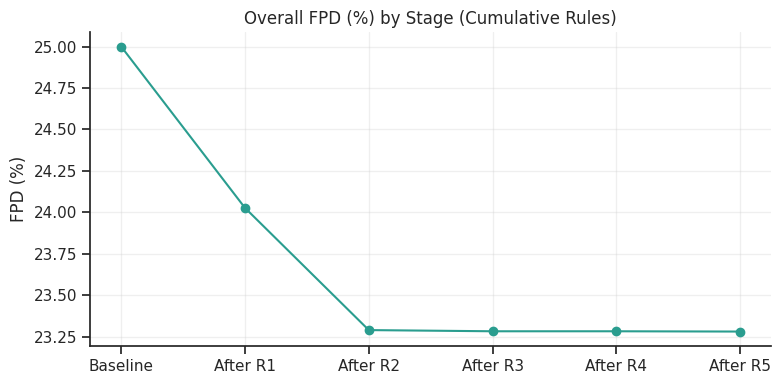

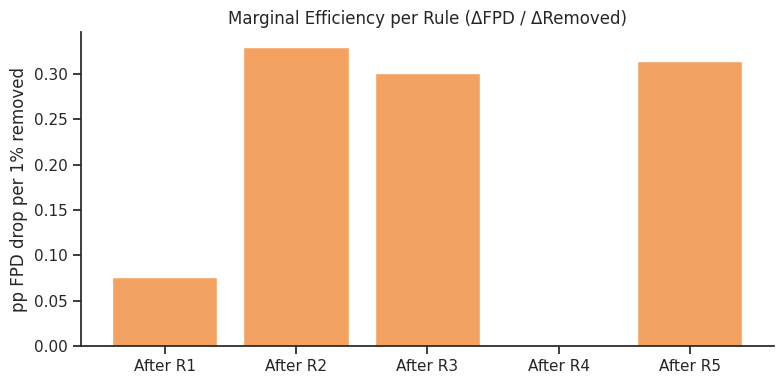

In [77]:
# ===============================
# EVALUATE IMPACT OF SELECTED RULES
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
TARGET_COL = "is_fpd"

selected_rules = [
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count <= 360.500",  # R1
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score <= 0.758",  # R4
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers <= 2.500",  # R5
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count > 360.500",   # R6
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score > 0.781", #R7
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers > 2.500", # R8
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score <= 0.781", # R9

]

# --- SAFETY: ensure numeric types for involved columns ---
for col in ["acquisition_uw_score", "apps_installed_count", "referrer_unique_referrers"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# --- helper to evaluate rules cumulatively ---
def evaluate_selected_rules(df, rules, target_col=TARGET_COL):
    N = len(df)
    kept = np.ones(N, dtype=bool)
    prev_kept_pct = 100.0
    prev_fpd = 100.0 * df[target_col].mean()
    rows = [{
        "stage": "Baseline",
        "k_rules": 0,
        "kept_n": kept.sum(),
        "kept_%": 100.0,
        "removed_%": 0.0,
        "overall_fpd_%": prev_fpd,
        "delta_removed_%": 0.0,
        "delta_fpd_pp": 0.0,
        "marginal_eff": np.nan
    }]
    masks = [kept.copy()]

    for i, rule in enumerate(rules, start=1):
        try:
            rm = pd.eval(rule, engine="python", local_dict=df)
        except Exception as e:
            print(f"⚠️ Error evaluating rule {i}: {e}")
            continue

        # Cumulative filtering
        kept = kept & (~rm)

        kept_n = kept.sum()
        kept_pct = 100.0 * kept.mean()
        removed_pct = 100.0 - kept_pct
        fpd = 100.0 * df.loc[kept, target_col].mean()

        delta_removed = prev_kept_pct - kept_pct
        delta_fpd = prev_fpd - fpd
        marginal_eff = (delta_fpd / delta_removed) if delta_removed > 1e-9 else np.nan

        rows.append({
            "stage": f"After R{i}",
            "k_rules": i,
            "kept_n": kept_n,
            "kept_%": kept_pct,
            "removed_%": removed_pct,
            "overall_fpd_%": fpd,
            "delta_removed_%": delta_removed,
            "delta_fpd_pp": delta_fpd,
            "marginal_eff": marginal_eff
        })

        prev_kept_pct, prev_fpd = kept_pct, fpd
        masks.append(kept.copy())

    stages_df = pd.DataFrame(rows)
    return stages_df, masks

# --- RUN EVALUATION ---
stages_df, masks = evaluate_selected_rules(df, selected_rules, target_col=TARGET_COL)

print("=== Impact of Selected Rules (Cumulative) ===")
display(stages_df)

# --- SUMMARY OF BASELINE VS FINAL ---
base_fpd = stages_df.loc[0, "overall_fpd_%"]
final_fpd = stages_df.iloc[-1]["overall_fpd_%"]
drop_pp = base_fpd - final_fpd
kept_pct = stages_df.iloc[-1]["kept_%"]

print(f"\nFinal summary after {len(selected_rules)} rules:")
print(f"  Applicants kept: {kept_pct:.2f}%")
print(f"  FPD reduced: {drop_pp:.2f} p.p.  (from {base_fpd:.2f}% → {final_fpd:.2f}%)")

# --- PLOT: FPD vs Stage ---
plt.figure(figsize=(8,4))
plt.plot(stages_df["stage"], stages_df["overall_fpd_%"], marker="o", color="#2a9d8f")
plt.title("Overall FPD (%) by Stage (Cumulative Rules)")
plt.ylabel("FPD (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT: Marginal efficiency ---
plt.figure(figsize=(8,4))
plt.bar(stages_df["stage"].iloc[1:], stages_df["marginal_eff"].iloc[1:], color="#f4a261")
plt.title("Marginal Efficiency per Rule (ΔFPD / ΔRemoved)")
plt.ylabel("pp FPD drop per 1% removed")
plt.axhline(0, color="gray", lw=1)
plt.tight_layout()
plt.show()

In [85]:
## MIX AND MATCH

# ================================
# Mix & Match Rule Evaluation
# ================================
import itertools
import numpy as np
import pandas as pd

# --- 1) Define your two rule sets ---
rules_A = [
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band <= 0.50 & bureau_2_perc_lines_in_use_band <= 1.50",  # A1
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band > 0.50",                                               # A2
    "risk_band > 4.50 & risk_band > 5.50 & apps_installed_count_missing_band <= 0.50 & bureau_2_perc_lines_in_use_band > 1.50"      # A3
]

rules_B = [
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count <= 360.500",  # B1
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count <= 471.000 & acquisition_uw_score <= 0.758",  # B4
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers <= 2.500",  # B5
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score > 0.523 & apps_installed_count > 360.500",   # B6
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score > 0.781",    # B7
    "acquisition_uw_score <= 0.838 & acquisition_uw_score <= 0.690 & acquisition_uw_score <= 0.523 & referrer_unique_referrers > 2.500", # B8
    "acquisition_uw_score <= 0.838 & acquisition_uw_score > 0.690 & apps_installed_count > 471.000 & acquisition_uw_score <= 0.781",   # B9
]

# --- 2) Ensure referenced columns exist (uses the helper you have) ---
all_rules = rules_A + rules_B
df = build_columns_for_rules(df, all_rules)

# Cast commonly-thresholded columns to numeric (idempotent)
for c in ['risk_band','acquisition_uw_score','apps_installed_count',
          'referrer_unique_referrers','bureau_2_perc_lines_in_use_band',
          'apps_installed_count_missing_band']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# --- 3) Eval helper (pd.eval with a restricted namespace) ---
def rule_mask(df: pd.DataFrame, rule: str) -> np.ndarray:
    ns = {c: df[c] for c in df.columns}  # safe, column-only scope
    # Replace double “<= and >” redundancies if you like, but not required
    return pd.eval(rule, engine='numexpr', local_dict=ns).astype(bool).values

# Cache masks so we don’t recompute
mask_cache = {}
for idx, r in enumerate(all_rules):
    try:
        mask_cache[r] = rule_mask(df, r)
    except Exception as e:
        print(f"⚠️ Could not evaluate rule {idx+1}: {e}")
        mask_cache[r] = np.zeros(len(df), dtype=bool)

# --- 4) Metric helper ---
TARGET = 'is_fpd'
base_fpd = df[TARGET].mean()
N = len(df)

def eval_combo(combo_rules):
    if not combo_rules:
        kept = np.ones(N, dtype=bool)
        lab  = "Baseline"
    else:
        remove = np.zeros(N, dtype=bool)
        for r in combo_rules:
            remove |= mask_cache[r]
        kept = ~remove
        lab = " OR ".join([f"R{all_rules.index(r)+1}" for r in combo_rules])

    kept_n = int(kept.sum())
    kept_pct = 100.0 * kept_n / N
    y_kept = df.loc[kept, TARGET]
    fpd = y_kept.mean() if kept_n > 0 else np.nan

    removed_pct = 100.0 * (1 - kept_n / N)
    fpd_reduction_pp = (base_fpd - fpd) * 100.0  # in percentage points
    efficiency = fpd_reduction_pp / (removed_pct + 1e-9)  # pp reduced per 1% removed

    return {
        "rules": lab,
        "n_rules": len(combo_rules),
        "kept_n": kept_n,
        "kept_%": kept_pct,
        "overall_fpd_%": fpd * 100.0 if pd.notna(fpd) else np.nan,
        "fpd_reduction_pp": fpd_reduction_pp,
        "removed_%": removed_pct,
        "efficiency_ratio": efficiency,
    }

# --- 5) Generate combinations ---
results = []

# A) Singles from A and B separately
for r in rules_A:
    results.append(eval_combo([r]))
for r in rules_B:
    results.append(eval_combo([r]))

# B) All A×B pairs (1 from A OR 1 from B)
for ra in rules_A:
    for rb in rules_B:
        results.append(eval_combo([ra, rb]))

# C) OPTIONAL: small triples (limit size to keep runtime acceptable)
#    e.g., 2 from A + 1 from B, and 1 from A + 2 from B
MAX_A_IN_TRIPLE = 3
MAX_B_IN_TRIPLE = 7

for a_count in [2, 1]:
    b_count = 3 - a_count
    if a_count <= MAX_A_IN_TRIPLE and b_count <= MAX_B_IN_TRIPLE:
        for combo_a in itertools.combinations(rules_A, a_count):
            for combo_b in itertools.combinations(rules_B, b_count):
                results.append(eval_combo(list(combo_a) + list(combo_b)))

mixmatch_df = pd.DataFrame(results).sort_values(
    ["fpd_reduction_pp", "efficiency_ratio"], ascending=[False, False]
).reset_index(drop=True)

print(f"Baseline FPD: {base_fpd*100:.2f}%  | Candidates: {N:,}")
# display(mixmatch_df.head(25))

all_combined_rules = rules_A + rules_B
result_all = eval_combo(all_combined_rules)
display(pd.DataFrame([result_all]))
# Save full table if useful
# mixmatch_df.to_csv("mixmatch_rule_search.csv", index=False)

/tmp/ipython-input-3428426009.py:42: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  return pd.eval(rule, engine='numexpr', local_dict=ns).astype(bool).values
/tmp/ipython-input-3428426009.py:42: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  return pd.eval(rule, engine='numexpr', local_dict=ns).astype(bool).values
/tmp/ipython-input-3428426009.py:42: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  return pd.eval(rule, engine='numexpr', local_dict=ns).astype(bool).values


Baseline FPD: 25.00%  | Candidates: 182,462


,rules,n_rules,kept_n,kept_%,overall_fpd_%,fpd_reduction_pp,removed_%,efficiency_ratio
0,R1 OR R2 OR R3 OR R4 OR R5 OR R6 OR R7 OR R8 O...,10,167592,91.850358,22.893098,2.106628,8.149642,0.258493
